<a href="https://colab.research.google.com/github/anuskagithub/FraudDetection_UsingMobileTransactions/blob/main/Fraud_Detection_using_mobile_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('dataset.csv')
# See number of rows and columns
print(df.shape)

print(df.head())


(6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

isFraud
0.0    314511
1.0       187
Name: count, dtype: int64


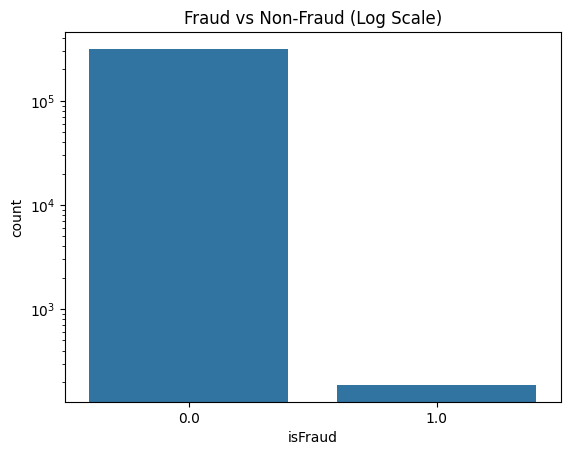

In [ ]:
print(df['isFraud'].value_counts())

sns.countplot(x='isFraud', data=df)
plt.yscale('log')
plt.title('Fraud vs Non-Fraud (Log Scale)')
plt.show()

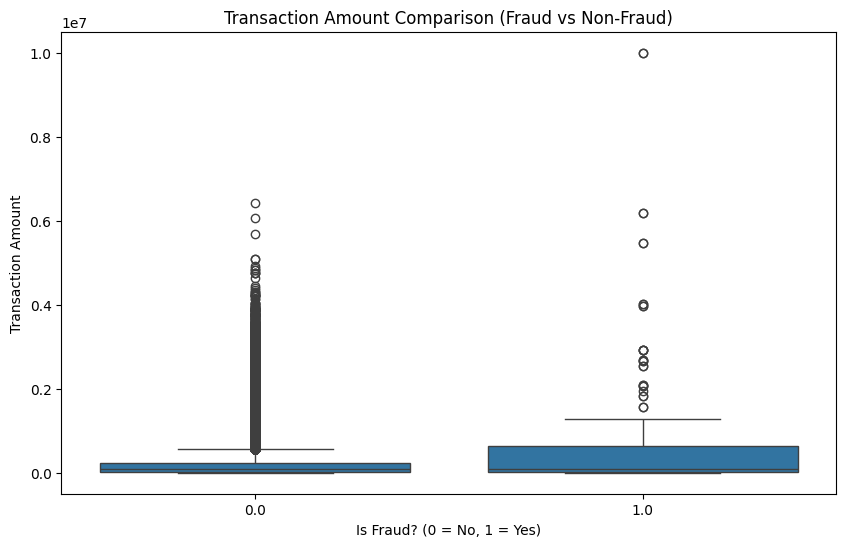

In [ ]:
plt.figure(figsize=(10,6))

sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount Comparison (Fraud vs Non-Fraud)')
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.ylabel('Transaction Amount')
plt.show()

type
CASH_OUT    110890
PAYMENT     108498
CASH_IN      66719
TRANSFER     26274
DEBIT         2318
Name: count, dtype: int64


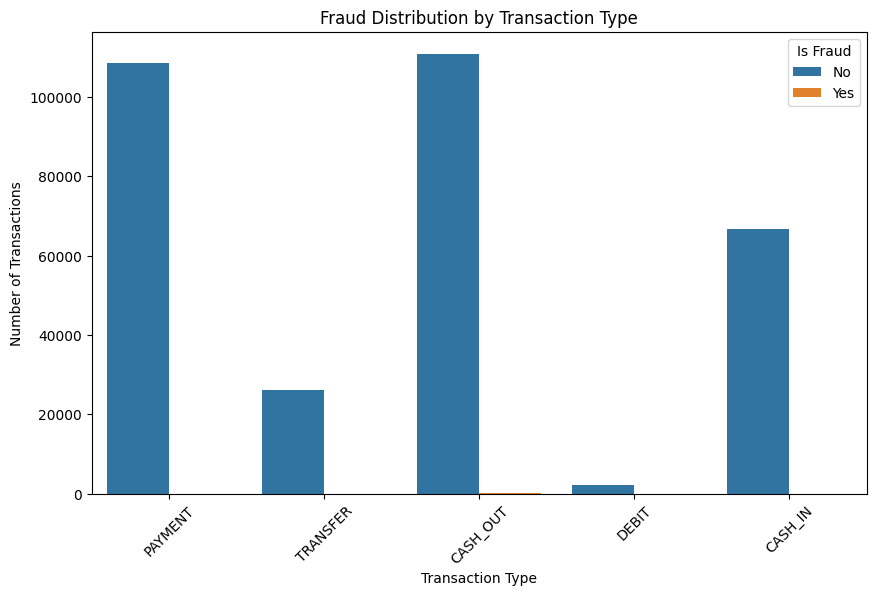

In [ ]:
print(df['type'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud', labels=['No', 'Yes'])
plt.xticks(rotation=45)  # if the type names are long
plt.show()



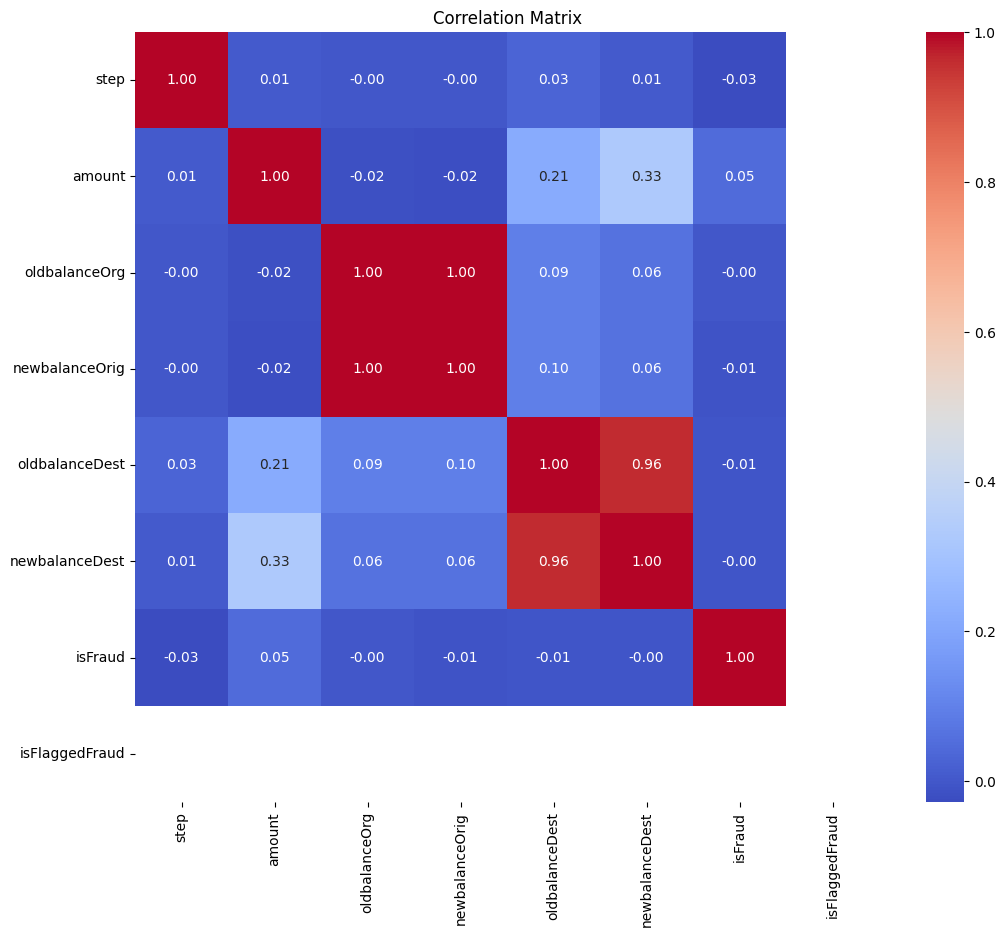

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# 1. Encode categorical variables (if 'type' is the only categorical variable)
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# 2. Split X and y
X = df.drop('isFraud', axis=1)  # Features
y = df['isFraud']  # Target variable

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Check for non-numeric columns (if any other categorical variables)
# Encode other categorical columns if needed or drop them
X_train = X_train.select_dtypes(exclude=['object'])  # Keep only numeric columns
X_test = X_test.select_dtypes(exclude=['object'])   # Keep only numeric columns

# 5. Scaling: Now apply scaling to only numeric columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
#HANDLING CLASS IMBALANCING
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to only the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optional: Check new class distribution
print("Original class distribution:", np.bincount(y_train))
print("Resampled class distribution:", np.bincount(y_train_resampled))

# Train the model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Original class distribution: [1399960    1501]
Resampled class distribution: [1399960 1399960]
Confusion Matrix:
 [[338447  11566]
 [    47    306]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    350013
           1       0.03      0.87      0.05       353

    accuracy                           0.97    350366
   macro avg       0.51      0.92      0.52    350366
weighted avg       1.00      0.97      0.98    350366


Accuracy Score: 0.9668546605549625


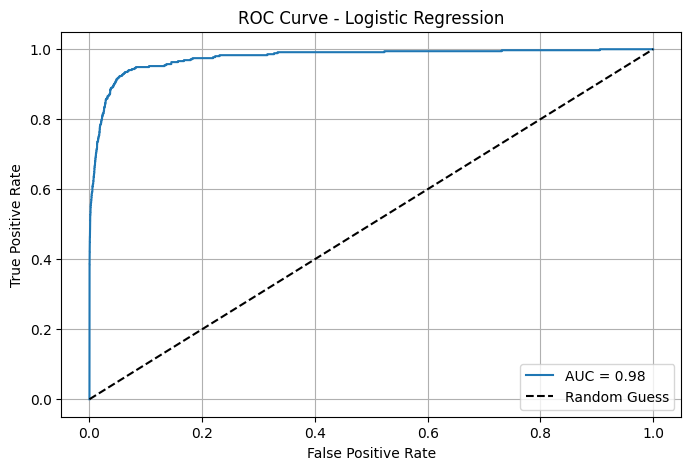

In [ ]:
#ROC-AUC Curve to visualize how well your model separates fraud vs non-fraud
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get prediction probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Using Random Forest

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
rf_pred = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, rf_pred))


Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    350013
           1       0.65      0.89      0.75       353

    accuracy                           1.00    350366
   macro avg       0.83      0.94      0.88    350366
weighted avg       1.00      1.00      1.00    350366



In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, xgb_pred))

XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    350013
           1       0.23      0.96      0.37       353

    accuracy                           1.00    350366
   macro avg       0.62      0.98      0.69    350366
weighted avg       1.00      1.00      1.00    350366

